Import Dependencies

In [2]:
#https://pypi.org/project/fastai/

#If installing using anaconda
#! conda install -c fastai -c pytorch -c anaconda fastai gh anaconda 

#If installing using pip install pytorch first 
#!pip install fastai
import zipfile
from fastbook import *
from fastai.vision.widgets import *

Unzip folder I uploaded to gradient notebook service

In [ ]:
path = Path()
x = path.ls(file_exts='.zip')
print(x)

with zipfile.ZipFile(x[0], 'r') as zip_ref:
    zip_ref.extractall(path)

In [24]:
path = Path('roofs') #all my images are in a folder called 'roofs'
print(path)
dls = ImageDataLoaders.from_folder(path, valid_pct = 0.2,seed=42, item_tfms=Resize(224))

learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(8)

roofs


epoch,train_loss,valid_loss,error_rate,time
0,2.481922,3.268829,0.727273,00:02


epoch,train_loss,valid_loss,error_rate,time
0,2.070263,2.521249,0.636364,00:03
1,2.033277,1.972268,0.681818,00:03
2,1.765913,1.449849,0.590909,00:03
3,1.478195,1.130592,0.409091,00:03
4,1.256068,0.986478,0.272727,00:03
5,1.063170,0.965954,0.318182,00:03
6,0.965430,0.933659,0.363636,00:03
7,0.864163,0.915132,0.318182,00:03


Confusion matrix only shows how well the model performed on the validation set

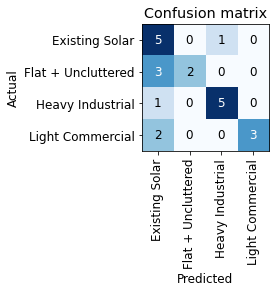

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The first 4 rows are all incorrect predictions

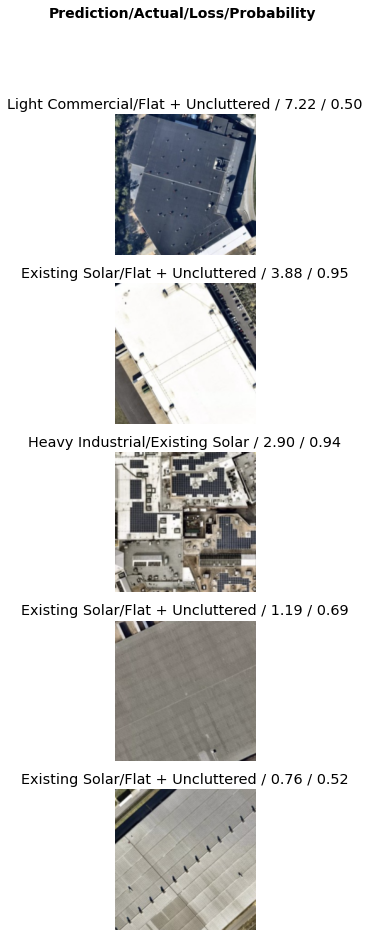

In [5]:
interp.plot_top_losses(5, nrows=5)

Now I will augment the images to hopefully make the model more accurate

## Playing around with different augmentations of the data. 
Making roofs a datablock object is quite nice 

In [8]:
roofs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(256))

dls = roofs.dataloaders(path)

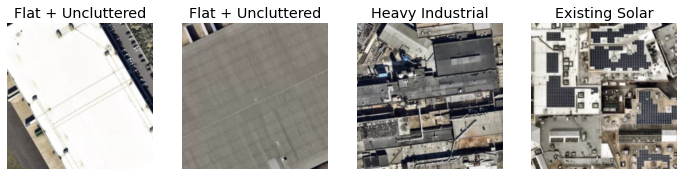

In [9]:
dls.valid.show_batch(max_n=4, nrows=1)

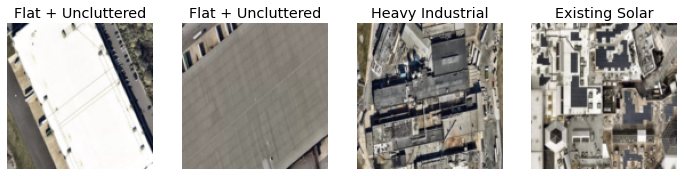

In [10]:
roofs = roofs.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = roofs.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

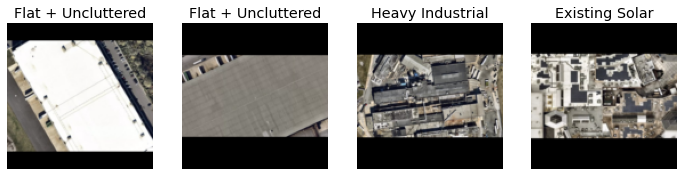

In [11]:
roofs = roofs.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = roofs.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

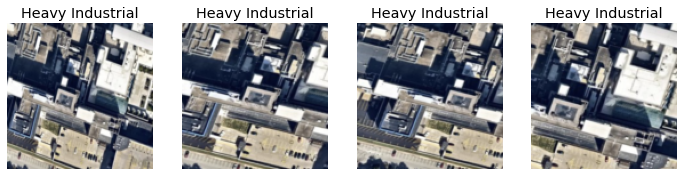

In [12]:
roofs = roofs.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = roofs.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

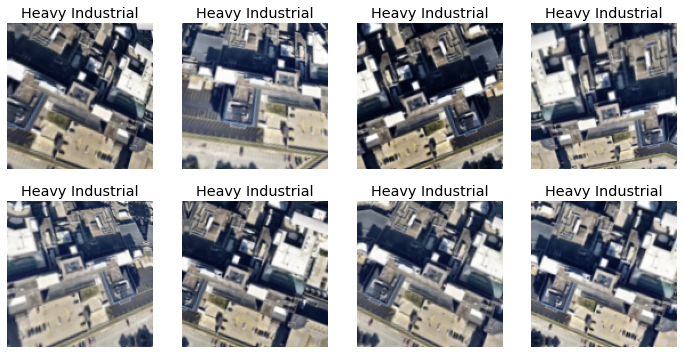

In [14]:
roofs = roofs.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=1))
dls = roofs.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

### Training a new model with augmentation #1

In [22]:
roofs = roofs.new(item_tfms=Resize(224, ResizeMethod.Pad, pad_mode='zeros'))
dls = roofs.dataloaders(path)

In [23]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(8)

epoch,train_loss,valid_loss,error_rate,time
0,2.826590,3.334837,0.818182,00:02


epoch,train_loss,valid_loss,error_rate,time
0,2.268651,2.586591,0.727273,00:03
1,2.017922,1.966369,0.727273,00:03
2,1.845530,1.441243,0.500000,00:03
3,1.588665,1.240844,0.409091,00:03
4,1.324295,1.163174,0.363636,00:03
5,1.148906,1.129481,0.318182,00:03
6,0.996825,1.113995,0.318182,00:03
7,0.872897,1.094377,0.272727,00:03


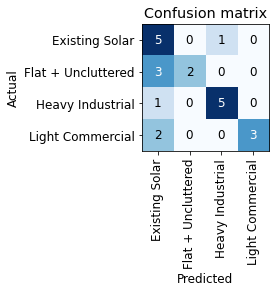

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

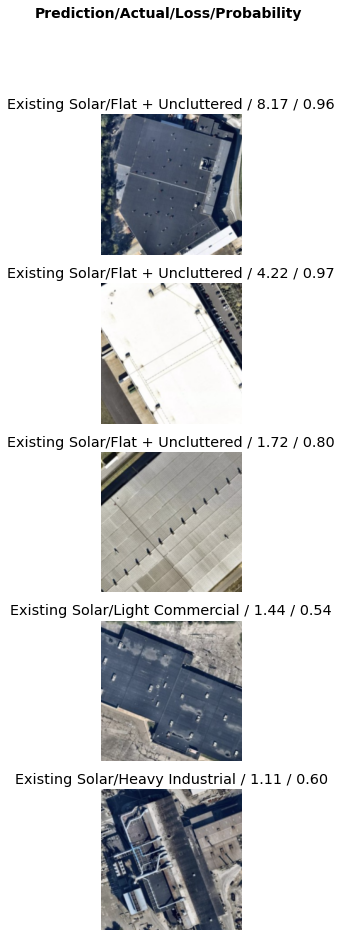

In [28]:
interp.plot_top_losses(5, nrows=5)

In [27]:
cleaner = ImageClassifierCleaner(learn)
cleaner

# So the model over predicts for existing solar roofs. Interesting. Top 5 loss images were all predicited as having solar panels.

## 3/5 images are mostly black on the roof. I can't explain why the second one is classified as solar. It's strinkingly white. 

### Need to look into methods that change the contrast maybe? I don't think the rotating the image or randomly cropping portions will help.

In [ ]:
#Either uncomment top line to delete image from dataset or uncomment the second line to reclassify the image
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)